In [93]:
! pip install -r requirements.txt --quiet

In [1]:
from dotenv import load_dotenv
from os import environ
from langchain_openai import AzureChatOpenAI
from typing_extensions import TypedDict,Literal
from langgraph.types import Command
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from  user_tools import get_weather_tool
from user_functions import vector_search  
from utils import pretty_print_messages
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits.openapi.toolkit import OpenAPIToolkit
from langchain_community.agent_toolkits.openapi.planner import create_openapi_agent
from langchain_community.utilities.requests import RequestsWrapper
from langchain_community.tools.json.tool import JsonSpec
from langchain_community.tools.openapi.utils.openapi_utils import OpenAPISpec
from langchain_community.agent_toolkits.openapi.spec import reduce_openapi_spec
from langchain_core.tools import tool

import requests
import json

load_dotenv(override=True)



members = ["document_search", "weather", "datacenterenergyusage"]

options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.n\nNote: The 'datacenterenergyusage' worker handles queries related to data center tabular quries on energy, power, or consumption topics."
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = AzureChatOpenAI(
        temperature=0,
        azure_deployment=environ["AZURE_OPENAI_MODEL"],
        api_version=environ["AZURE_OPENAI_API_VERSION"]
    )




In [2]:
spec_url = environ['OPENAPI_URL']
response = requests.get(spec_url)
response.raise_for_status()

json_spec = reduce_openapi_spec(response.json())

requests_wrapper = RequestsWrapper(headers={"Authorization": f"Bearer {environ['AZURE_OPENAI_API_KEY']}"})

openapi_agent = create_openapi_agent(
    json_spec,
    requests_wrapper,
    llm,
    allow_dangerous_requests=True,
)

In [3]:
llm_with_tools = create_react_agent(llm, tools=[get_weather_tool])

In [4]:

def document_search(state: MessagesState) -> Command[Literal["supervisor"]]:
    messages = state["messages"]
    last_user_message = next((msg for msg in reversed(messages)), None)
    if not last_user_message:
        return Command(goto="supervisor")

    query = last_user_message.content
    context = vector_search(query)  

    
    messages.append(
    SystemMessage(
        content=(
            f"You are a helpful assistant. Use only the information in the context below to answer the user's question. "
            f"If the context does not contain the answer, respond with \"I don't know.\"\n\nContext:\n{context}"
        )
    )
    )

    response = llm.invoke(messages)

    return Command(
        update={
            "messages": [
                HumanMessage(content=response.content, name="document_search")
            ]
        },
        goto="supervisor",
    )


def weather(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = llm_with_tools.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="weather")
            ]
        },
        goto="supervisor",
    )


def datacenterenergyusage(state: MessagesState) -> Command[Literal["supervisor"]]:
    user_message = next(
        (msg.content for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)),
        None
    )

    if not user_message:
        raise ValueError("No user message found in state.")

    result = openapi_agent.invoke({"input": user_message})
    final_output = result.get("output", result)  

    return Command(
        update={
            "messages": [
                HumanMessage(content=final_output, name="datacenterenergyusage")
            ]
        },
        goto="supervisor",
    )


def supervisor(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})




In [5]:

builder = StateGraph(MessagesState)
builder.add_node("document_search", document_search)
builder.add_node("weather", weather)
builder.add_node("datacenterenergyusage", datacenterenergyusage)
builder.add_node("supervisor", supervisor)

builder.set_entry_point("supervisor")

graph = builder.compile()


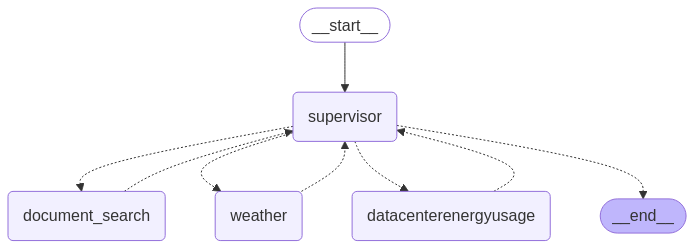

In [6]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
for step in graph.stream({"messages": [{"role": "user", "content": "What data centers are in 'critical'?"}]}):
   pretty_print_messages(step)

Update from node supervisor:






> Entering new AgentExecutor chain...
Action: api_planner  
Action Input: I need to find the right API calls to retrieve information about data centers with a 'critical' status.  
Observation: 1. Evaluate the query: Yes, the user query can be solved by the API documented. The endpoint `GET /usage/energy-usage` allows filtering by `alarm_status`, which includes 'critical'.

2. Plan:
   - Step 1: Use the `GET /usage/energy-usage` endpoint with the query parameter `alarm_status=critical` to retrieve information about data centers with a 'critical' status.
Thought:Thought: I have the plan to retrieve information about data centers with a 'critical' status. I should now execute the plan using the API controller.  
Action: api_controller  
Action Input: Use the `GET /usage/energy-usage` endpoint with the query parameter `alarm_status=critical` to retrieve information about data centers with a 'critical' status.  

> Entering new AgentExecutor chain...
I nee

In [8]:
for step in graph.stream({"messages": [{"role": "user", "content": "What are the Data Center Space Types?"}]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node document_search:


================================ Human Message =================================
Name: document_search

The data center space types considered in the study are:

1. **Telco Edge**: Small closets/rooms to micro data centers and network infrastructure deployed by communications companies as points of presence throughout their network.

2. **Commercial Edge**: Network closets, server rooms, and micro-data centers supporting digital infrastructure and software delivery services for commercial and industrial edge locations.

3. **Small and Medium Businesses (SMB)**: Data center deployments within internal facilities of small and medium businesses.

4. **Enterprise Branch**: Remote and branch office (ROBO) deployments for large enterprises in their own internal facilities, such as network closets and server rooms.

5. **Internal**: Data centers operated internally by enterprises for their own use.

6. **Communications Servi

In [9]:
for step in graph.stream({"messages": [{"role": "user", "content": "what is the weather in sf"}]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node weather:


================================ Human Message =================================
Name: weather

The weather in San Francisco is currently 60°F and foggy.


Update from node supervisor:




